<a href="https://colab.research.google.com/github/githma2000/liver-tumor-segmentation/blob/main/tumor-segmentation6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

DATASET_PATH = '/content/drive/MyDrive/Preprocessed_3Dircadb'


In [3]:
import os
import random
import shutil

base_dir = '/content/drive/MyDrive/Preprocessed_3Dircadb'
all_patients = sorted([f for f in os.listdir(base_dir) if f.startswith('3Dircadb')])

# Shuffle and split
random.seed(42)
random.shuffle(all_patients)

train_split = int(0.7 * len(all_patients))
val_split = int(0.85 * len(all_patients))

train_patients = all_patients[:train_split]
val_patients = all_patients[train_split:val_split]
test_patients = all_patients[val_split:]

print("Train:", train_patients)
print("Val:", val_patients)
print("Test:", test_patients)


Train: ['3Dircadb1.9', '3Dircadb1.14', '3Dircadb1.4', '3Dircadb1.13', '3Dircadb1.18', '3Dircadb1.3', '3Dircadb1.5', '3Dircadb1.8', '3Dircadb1.15', '3Dircadb1.20', '3Dircadb1.7', '3Dircadb1.19', '3Dircadb1.10', '3Dircadb1.2']
Val: ['3Dircadb1.11', '3Dircadb1.6', '3Dircadb1.16']
Test: ['3Dircadb1.17', '3Dircadb1.1', '3Dircadb1.12']


In [109]:
from tensorflow.keras.utils import Sequence
import numpy as np
import os
import random
import albumentations as A

class IRCADNPYDataset(Sequence):
    def __init__(self, patient_list, base_path, batch_size=8, input_size=(256, 256),
                 shuffle=True, balance_data=True, seed=42):
        self.patient_list = patient_list
        self.base_path = base_path
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.balance_data = balance_data
        self.seed = seed

        # 🔒 Set seeds for reproducibility
        random.seed(self.seed)
        np.random.seed(self.seed)

        # 🎲 Albumentations augmentations
        self.augment = A.Compose([
            A.Resize(height=self.input_size[0], width=self.input_size[1]),

            A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.3),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=10, p=0.2),
            A.RandomBrightnessContrast(p=0.2),
            A.GaussianBlur(blur_limit=(3, 5), p=0.1),
        ], additional_targets={'mask': 'mask'})

        self.data = self._load_all_files()
        self.on_epoch_end()

    def _load_all_files(self):
        tumor_data = []
        non_tumor_data = []

        for patient in self.patient_list:
            img_dir = os.path.join(self.base_path, patient, 'PATIENT_2_5D')
            mask_dir = os.path.join(self.base_path, patient, 'LABEL_2_5D')

            img_files = sorted(os.listdir(img_dir))
            mask_files = sorted(os.listdir(mask_dir))

            for img_file, mask_file in zip(img_files, mask_files):
                img_path = os.path.join(img_dir, img_file)
                mask_path = os.path.join(mask_dir, mask_file)

                if os.path.isfile(img_path) and os.path.isfile(mask_path):
                    mask = np.load(mask_path).astype(np.float32)

                    if mask.ndim == 2:
                        mask = np.expand_dims(mask, axis=-1)
                    elif mask.ndim == 3 and mask.shape[2] > 1:
                        mask = mask[..., 0:1]

                    min_val = np.min(mask)
                    max_val = np.max(mask)
                    threshold = min_val + (max_val - min_val) * 0.1
                    binary_mask = (mask > threshold).astype(np.float32)

                    if np.any(binary_mask > 0):
                        tumor_data.append((img_path, mask_path))
                    else:
                        non_tumor_data.append((img_path, mask_path))

        # Balance tumor vs. non-tumor data
        if self.balance_data and len(non_tumor_data) > 0:
            sampled_non_tumor = random.sample(non_tumor_data, min(len(tumor_data), len(non_tumor_data)))
            combined_data = tumor_data + sampled_non_tumor
        else:
            combined_data = tumor_data + non_tumor_data

        return combined_data

    def __len__(self):
        return max(1, len(self.data) // self.batch_size)

    def __getitem__(self, idx):
        batch_pairs = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        images, masks = [], []

        for img_path, mask_path in batch_pairs:
            img = np.load(img_path).astype(np.float32)
            mask = np.load(mask_path).astype(np.float32)

            if mask.ndim == 2:
                mask = np.expand_dims(mask, axis=-1)
            elif mask.ndim == 3 and mask.shape[2] > 1:
                mask = mask[..., 0:1]

            # Z-score normalization
            img = (img - np.mean(img)) / (np.std(img) + 1e-5)

            # Binarize mask
            min_val = np.min(mask)
            max_val = np.max(mask)
            threshold = min_val + (max_val - min_val) * 0.1
            mask = (mask > threshold).astype(np.float32)

            # Augmentation
            augmented = self.augment(image=img, mask=mask)
            img_aug = augmented['image']
            mask_aug = augmented['mask']

            # Ensure shape is (H, W, C)
            if img_aug.ndim == 2:
                img_aug = np.expand_dims(img_aug, axis=-1)
            if mask_aug.ndim == 2:
                mask_aug = np.expand_dims(mask_aug, axis=-1)

            images.append(img_aug)
            masks.append(mask_aug)

        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        if self.shuffle:
            random.seed(self.seed)
            random.shuffle(self.data)


In [93]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

def ASPP(x, filters):
    """Atrous Spatial Pyramid Pooling with Keras-compatible operations"""
    shape = x.shape

    y1 = Conv2D(filters, 1, padding="same", use_bias=False)(x)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)

    y2 = Conv2D(filters, 3, padding="same", dilation_rate=6, use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filters, 3, padding="same", dilation_rate=12, use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filters, 3, padding="same", dilation_rate=18, use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    # Use GlobalAveragePooling2D and reshape for broadcast
    y5 = tf.keras.layers.GlobalAveragePooling2D()(x)
    y5 = tf.keras.layers.Reshape((1, 1, shape[-1]))(y5)
    y5 = Conv2D(filters, 1, padding="same", use_bias=False)(y5)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)
    y5 = UpSampling2D(size=(shape[1], shape[2]), interpolation="bilinear")(y5)

    y = concatenate([y1, y2, y3, y4, y5])
    y = Conv2D(filters, 1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y


def DeeplabV3Plus(input_shape=(256, 256, 3), num_classes=1):
    """Custom DeepLabV3+ model with ResNet50 backbone"""
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Use features from different levels of the encoder
    image_features = base_model.get_layer("conv4_block6_2_relu").output
    x = ASPP(image_features, 256)

    x = UpSampling2D(size=(4, 4), interpolation="bilinear")(x)

    low_level_feat = base_model.get_layer("conv2_block3_2_relu").output
    low_level_feat = Conv2D(48, 1, padding="same", use_bias=False)(low_level_feat)
    low_level_feat = BatchNormalization()(low_level_feat)
    low_level_feat = Activation("relu")(low_level_feat)

    x = concatenate([x, low_level_feat])
    x = Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = UpSampling2D(size=(4, 4), interpolation="bilinear")(x)
    x = Conv2D(num_classes, 1, padding="same", activation="sigmoid")(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model



In [94]:
import tensorflow as tf

# 1. Define loss function
def dice_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2. * intersection + 1) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1)

# 2. Define metric function
def iou_metric(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + 1) / (union + 1)

# 3. Define and compile model
model = DeeplabV3Plus(input_shape=(256, 256, 3), num_classes=1)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=dice_loss,
    metrics=[iou_metric]
)

In [54]:
!pip install -U tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 112.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 125.1 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorfl

In [98]:

train_dataset = IRCADNPYDataset(
    train_patients,
    base_dir,
    batch_size=8,
    shuffle=True,
    balance_data=True  # Balance training data
)

val_dataset = IRCADNPYDataset(
    val_patients,
    base_dir,
    batch_size=8,
    shuffle=False,
    balance_data=False  # Keep validation distribution unchanged
)

test_dataset = IRCADNPYDataset(
    test_patients,
    base_dir,
    batch_size=8,
    shuffle=False,
    balance_data=False  # Same for test
)


<ipython-input-97-dc979a059531>:31: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=10, p=0.2),


In [99]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

early_stop = EarlyStopping(
    monitor='val_iou_metric',
    patience=7,
    restore_best_weights=True,
    mode='max',
    verbose=1
)


checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/best_deeplab_model.keras',
    monitor='val_iou_metric',
    save_best_only=True,
    mode='max',
    verbose=1
)

lr_schedule = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    mode='min',
    min_lr=1e-6
)



history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    batch_size=16,
    callbacks=[early_stop, checkpoint, lr_schedule]
)


Epoch 1/100
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - iou_metric: 0.2156 - loss: 0.6531
Epoch 1: val_iou_metric improved from -inf to 0.20678, saving model to /content/drive/MyDrive/best_deeplab_model.keras
233/233 ━━━━━━━━━━━━━━━━━━━━ 136s 333ms/step - iou_metric: 0.2159 - loss: 0.6527 - val_iou_metric: 0.2068 - val_loss: 0.6678 - learning_rate: 1.0000e-05
Epoch 2/100
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - iou_metric: 0.4186 - loss: 0.4168
Epoch 2: val_iou_metric improved from 0.20678 to 0.31560, saving model to /content/drive/MyDrive/best_deeplab_model.keras
233/233 ━━━━━━━━━━━━━━━━━━━━ 75s 323ms/step - iou_metric: 0.4186 - loss: 0.4167 - val_iou_metric: 0.3156 - val_loss: 0.5451 - learning_rate: 1.0000e-05
Epoch 3/100
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - iou_metric: 0.4911 - loss: 0.3470
Epoch 3: val_iou_metric improved from 0.31560 to 0.36007, saving model to /content/drive/MyDrive/best_deeplab_model.keras
233/233 ━━━━━━━━━━━━━━━━━━━━ 76s 325ms/step - iou_metric: 0

In [100]:
import numpy as np
import cv2
from scipy.ndimage import binary_fill_holes, label
from skimage.morphology import remove_small_objects, remove_small_holes, binary_closing

def postprocess_mask(mask, threshold=0.5, min_size=100):
    """
    Post-process a single predicted mask:
    - Threshold
    - Fill holes
    - Remove small objects
    - Morphological closing
    """
    # Binarize
    binary = (mask > threshold).astype(np.uint8)

    # Fill small holes
    binary = binary_fill_holes(binary).astype(np.uint8)

    # Remove small objects
    binary = remove_small_objects(binary.astype(bool), min_size=min_size).astype(np.uint8)

    # Optional: Morphological closing to smooth edges
    binary = binary_closing(binary, selem=np.ones((3, 3))).astype(np.uint8)

    return binary


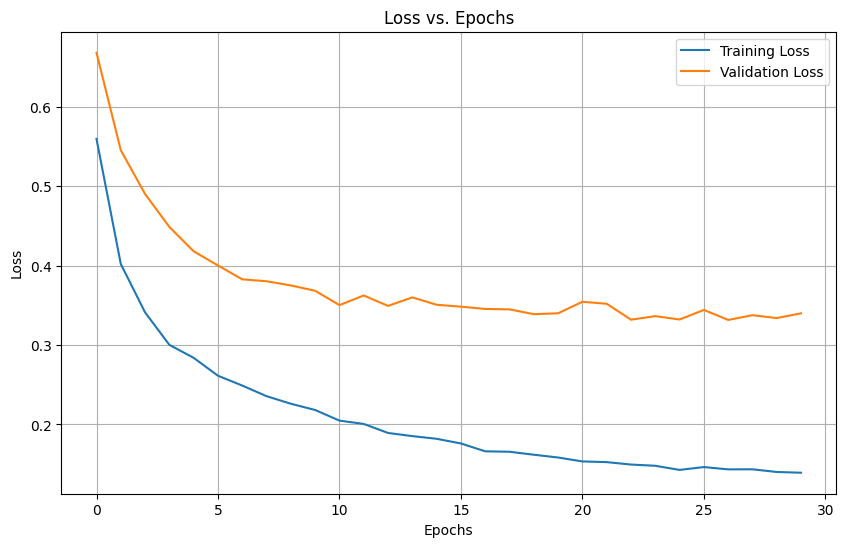

In [101]:
import matplotlib.pyplot as plt

# Assuming 'history' is the result of your model.fit() call
# Access training & validation loss history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


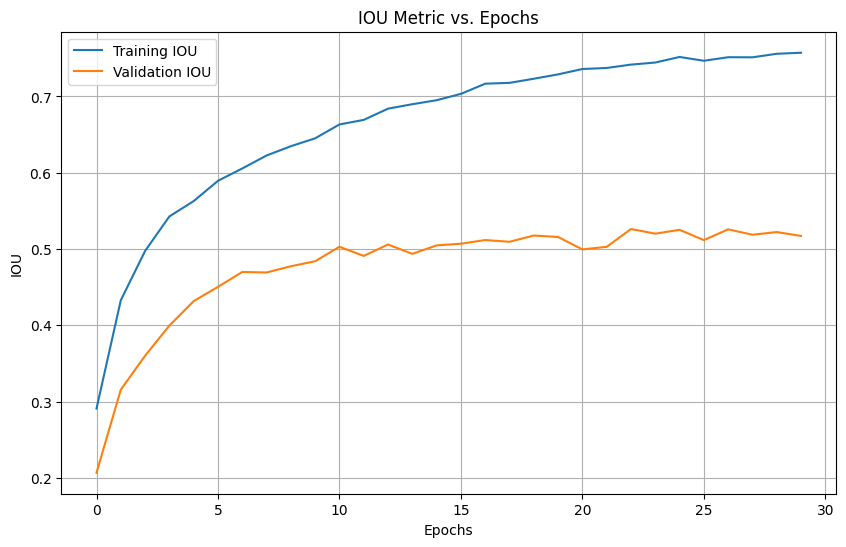

In [102]:
# Access training & validation IOU history
train_iou = history.history['iou_metric']
val_iou = history.history['val_iou_metric']

# Plotting IOU curves
plt.figure(figsize=(10, 6))
plt.plot(train_iou, label='Training IOU')
plt.plot(val_iou, label='Validation IOU')
plt.title('IOU Metric vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.grid(True)
plt.show()


In [104]:
!pip install medpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 15.5 MB/s eta 0:00:00
  Created wheel for medpy: filename=MedPy-0.5.2-py3-none-any.whl size=224710 sha256=0fb20b60a10b3312324671026ae4bdaea7332c72cf09bd5803e72bd5d5b5ea3b
  Stored in directory: /root/.cache/pip/wheels/d4/33/ed/aaac5a347fb8d41679ca515b8f5c49dfdf49be15bdbb9a905d
Successfully built medpy


In [112]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, jaccard_score

def evaluate_predictions(y_true, y_pred):
    # Convert lists to NumPy arrays if they are lists of arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Ensure both arrays are flattened to 1D for comparison
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred, average='binary'),
        'IoU': jaccard_score(y_true, y_pred, average='binary')
    }

    return metrics


In [113]:
# Predict on the validation set
y_pred = model.predict(validation_images)

# Post-process each prediction
y_pred_pp = [postprocess_mask(p) for p in y_pred]

# Evaluate the predictions
metrics = evaluate_predictions(y_true=validation_masks, y_pred=y_pred_pp)

# Print the evaluation metrics
print("Evaluation after post-processing:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 352ms/step
Evaluation after post-processing:
Accuracy: 0.9219
F1 Score: 0.7070
IoU: 0.5467


In [1]:
import numpy as np

def rmsd(pred_mask, true_mask):
    pred_points = np.argwhere(pred_mask)
    true_points = np.argwhere(true_mask)

    if pred_points.size == 0 or true_points.size == 0:
        return np.nan  # Cannot compute RMSD without points

    distances = np.linalg.norm(pred_points[:, None] - true_points[None, :], axis=2)
    min_distances = np.min(distances, axis=1)
    return np.sqrt(np.mean(min_distances ** 2))

# Convert to NumPy arrays
y_pred_np = np.array(y_pred_pp)
y_true_np = np.array(validation_masks)

# Make sure they're binary (if not already)
y_pred_bin = (y_pred_np > 0.5).astype(np.uint8)
y_true_bin = (y_true_np > 0.5).astype(np.uint8)

# Compute RMSD for each pair
rmsd_scores = []
for pred, true in zip(y_pred_bin, y_true_bin):
    rmsd_value = rmsd(pred.squeeze(), true.squeeze())  # Remove channel dim if exists
    if not np.isnan(rmsd_value):
        rmsd_scores.append(rmsd_value)

# Mean RMSD across dataset
mean_rmsd = np.mean(rmsd_scores)
print(f"Mean RMSD: {mean_rmsd:.4f}")


NameError: name 'y_pred_pp' is not defined

In [88]:
from scipy.ndimage import binary_erosion

def get_surface(mask):
    eroded = binary_erosion(mask)
    surface = mask ^ eroded  # XOR: Surface pixels only
    return surface


In [114]:
import numpy as np
from scipy.spatial.distance import directed_hausdorff
from scipy.ndimage import distance_transform_edt

def dice_coefficient(pred, gt):
    intersection = np.logical_and(pred, gt).sum()
    return (2. * intersection) / (pred.sum() + gt.sum())

def voe(pred, gt):
    intersection = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    return 1 - (intersection / union)

def rvd(pred, gt):
    return (pred.sum() - gt.sum()) / gt.sum()
def assd(pred, gt):
    pred_surface = get_surface(pred)
    gt_surface = get_surface(gt)
    if np.sum(pred_surface) == 0 or np.sum(gt_surface) == 0:
        return np.nan  # Surface not found
    pred_dist = distance_transform_edt(~pred_surface)
    gt_dist = distance_transform_edt(~gt_surface)
    surface_distances = np.concatenate([
        pred_dist[gt_surface],
        gt_dist[pred_surface]
    ])
    return surface_distances.mean()

def rmsd(pred, gt):
    pred_surface = get_surface(pred)
    gt_surface = get_surface(gt)
    if np.sum(pred_surface) == 0 or np.sum(gt_surface) == 0:
        return np.nan  # Surface not found
    pred_dist = distance_transform_edt(~pred_surface)
    gt_dist = distance_transform_edt(~gt_surface)
    surface_distances = np.concatenate([
        pred_dist[gt_surface],
        gt_dist[pred_surface]
    ])
    return np.sqrt((surface_distances ** 2).mean())


# Example usage
# pred_mask and gt_mask should be binary (0 and 1) masks

# Example dummy masks (replace with your real predictions)
pred_mask = np.random.randint(0, 2, (256, 256))
gt_mask = np.random.randint(0, 2, (256, 256))

dice = dice_coefficient(pred_mask, gt_mask)
voe_score = voe(pred_mask, gt_mask)
rvd_score = rvd(pred_mask, gt_mask)
assd_score = assd(pred_mask, gt_mask)
rmsd_score = rmsd(pred_mask, gt_mask)

print(f"Dice Coefficient: {dice:.4f}")
print(f"VOE: {voe_score:.4f}")
print(f"RVD: {rvd_score:.4f}")
print(f"ASSD: {assd_score:.4f}")
print(f"RMSD: {rmsd_score:.4f}")


Dice Coefficient: 0.5016
VOE: 0.6652
RVD: -0.0043
ASSD: 127.5323
RMSD: 147.3768


In [49]:
import cv2
def remove_small_components(pred_mask, min_size=500):
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(pred_mask.astype(np.uint8), connectivity=8)
    new_mask = np.zeros_like(pred_mask)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_size:
            new_mask[labels == i] = 1
    return new_mask


In [14]:
import matplotlib.pyplot as plt

def show_sample(image, gt_mask, pred_mask):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image[..., 0], cmap='gray')
    plt.title('Input Image')
    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask[..., 0], cmap='gray')
    plt.title('Ground Truth')
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask[..., 0], cmap='gray')
    plt.title('Prediction')
    plt.show()
